<a href="https://colab.research.google.com/github/WilliamQin65/cap-comp215/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import time
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [ ]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [7]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [11]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 0, 0]])


    def __init__(self, n, p=0.01, f=0.001, q=0.5, wind_speed=0, wind_direction=0):
        """Initializes the model.
        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        wind_speed: wind speed in km/h
        wind_direction: direction of wind in degrees(0 is east, 30 is south, 60 is north, 90 is east)
        """
        self.n = n
        self.q = q
        self.p = p
        self.f = f
        self.wind_speed = wind_speed
        self.wind_direction = wind_direction
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])
        
    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest.
        """
        # calculate the x and y components of the wind vector
        wind_x = - self.wind_speed * np.sin(np.radians(self.wind_direction))
        wind_y = - self.wind_speed * np.cos(np.radians(self.wind_direction))

        # TODO: define the rules for the CA. This is a significant challenge b/c there are 4 rules and they must act independently!
        on_fire = self.array == self.FIRE
        empty = self.array == self.EMPTY
        forested = self.array == self.OCCUPIED

        # step 1: An empty cell becomes occupied with probability p.
        empty_cells = np.random.random(self.array.shape) < self.p
        self.array[empty & empty_cells] = self.OCCUPIED
        # step 2: A cell with a tree burns if any of its neighbors is on fire with wind correlation.
        correlate = correlate2d(forested, self.kernel, mode='same', boundary='wrap')
        wind_corr = correlate2d(forested, self.kernel * wind_x, mode='same', boundary='wrap') + correlate2d(forested, self.kernel * wind_y, mode='same', boundary='wrap')
        self.array[correlate > 0] = self.FIRE
        self.array[wind_corr > 0] = self.FIRE
        # step 3: A cell with a tree spontaneously burns, with probability f, even if none of its neighbors is on fire.
        s_burn = np.random.random(self.array.shape) < self.f
        # step 4: A cell with a burning tree becomes an empty cell in the next time step.
        self.array[on_fire] = self.EMPTY

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return np.sum(self.array == self.OCCUPIED)

    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

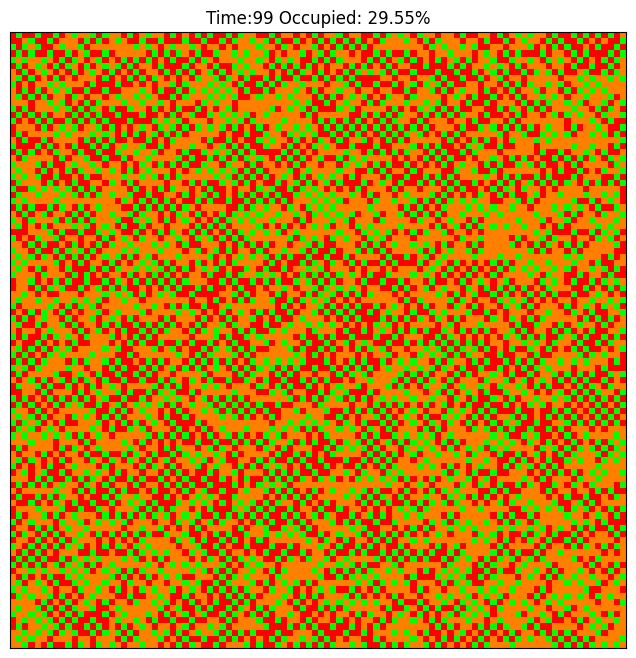

In [12]:
f = ForestFire(100,0.01,0.001,0.5,100,30)
Animation = Animation2D(f,frames = 100, steps_per_frame = 1)
Animation.animate(0.3)

For each feature you add, re-run some of the experiments we did in the lab and compare the new model
behaviour with the original to determine in what ways the additional feature changes its behaviour and what
we might learn from that...
1. Are the results similar to those from the simpler model?
2. If they are different, in what ways (qualitative and quantitative).
In what ways might the extended model contribute to our understanding of fire-mediated landscape
patterns?
3. Are there scientific questions you could answer with the extended model that are not well-suited to the
simpler model? What about the other way around?

Display your results with at least one animation and one chart, and provide a short discussion that addresses at
least some of the questions above.

1.It can lead to a different results compared with the simpler model.

2.I add the wind speed and wind direction into my code. It helps understand hoe does the wind affect the spread of the fire and the size of burned areas.

3.The simpler model can understand better on the basic fire spreading and its own behaviour.


**What is the Big-O time complexity of the algorithm we are using here to simulate this system?
What implications does that have for running larger or longer CA experiments?**


The Big-O time complexity of the algorithm we are using here is O(n^4). N means the dimension of the square array. As the size of the array increases,the time it takes to take execute the time step will also increase. Running larger or longer CA experiments will take a lot of time to execute, we should limit the size and duration of the experiment. We can optimize the algorithm.

**Use Python’s timeit to do some actual timings to support your algorithm analysis.**

---



In [14]:
import timeit
# create a ForestFire object with n=100
ff = ForestFire(100)
# measure the execution time of the step() method
time_taken = timeit.timeit(ff.step, number=100)
print(f"Time taken: {time_taken:.2f} seconds")

Time taken: 0.19 seconds


**Early in the Chapter 8 notebook, the author makes some efficiency improvements to the basic
algorithm. Do these improvements change the Big-O time complexity?
Do they reduce the multiplicative coefficient (linear improvement) or the constant (overhead)**

These improvements do not change the Big-O time complexity. They reduce the multiplicative coefficient or the constant by making it faster and in a long-running simulations. It helps reduce the runtime of the algorithm.